In [191]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

In [192]:
data = pd.read_csv('Downloads/CSVs/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')

/Users/ozalmanson/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (20,21,85) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [193]:
data[' Flow Packets/s'] = data[' Flow Packets/s'].astype('float64')
data['Flow Bytes/s'] = data['Flow Bytes/s'].astype('float64')
data[' Timestamp'] = pd.to_datetime(data[' Timestamp'], format = '%m/%d/%Y %H:%M')
data = data.replace([np.inf, -np.inf], np.nan)

In [194]:
src_ip_num = data[' Source IP'].str.split('.', expand = True)
src_ip_num.columns = ['src_a', 'src_b', 'src_c','src_d']
src_ip_num = src_ip_num.applymap(int)
dest_ip_num = data[' Destination IP'].str.split('.', expand = True)
dest_ip_num.columns = ['dest_a', 'dest_b', 'dest_c','dest_d']
dest_ip_num = dest_ip_num.applymap(int)

In [195]:
data = data.merge(dest_ip_num, left_index = True, right_index = True)
data = data.merge(src_ip_num, left_index = True, right_index = True)

In [196]:
data['time_diff'] = (data[' Timestamp'] - data[' Timestamp'].shift(1)).astype('timedelta64[s]')

In [197]:
non_trainable = ['Flow ID', ' Source IP', ' Destination IP', ' Timestamp', 'External IP', ' Label']

In [249]:
train = data[data[' Timestamp'] < '2017-07-07 04:15:00']

In [250]:
test = data[data[' Timestamp'] >= '2017-07-07 04:15:00']

In [251]:
len(test) / len(data)

0.17103811823074708

In [252]:
sum(test[' Label'].apply(lambda val: 1 if val == 'DDoS' else 0))

4307

In [253]:
scaler = StandardScaler()

In [254]:
scaled_train_X = scaler.fit_transform(train[[column for column in train.columns if column not in non_trainable]].fillna(0))

In [255]:
scaled_test_X = scaler.transform(test[[column for column in test.columns if column not in non_trainable]].fillna(0))

In [256]:
train_Y = train[' Label'].apply(lambda val: 1 if val == 'DDoS' else 0)

In [257]:
test_Y = test[' Label'].apply(lambda val: 1 if val == 'DDoS' else 0)

In [258]:
scaled_train_X = scaled_train_X.reshape((scaled_train_X.shape[0], 1, scaled_train_X.shape[1]))
scaled_test_X = scaled_test_X.reshape((scaled_test_X.shape[0], 1, scaled_test_X.shape[1]))

In [ ]:
%matplotlib inline

Train on 187134 samples, validate on 38611 samples
Epoch 1/50
 - 11s - loss: 0.2253 - val_loss: 0.2010
Epoch 2/50
 - 9s - loss: 0.0984 - val_loss: 0.2382
Epoch 3/50
 - 9s - loss: 0.0596 - val_loss: 0.3967
Epoch 4/50
 - 9s - loss: 0.0592 - val_loss: 0.0564
Epoch 5/50
 - 9s - loss: 0.0640 - val_loss: 0.0181
Epoch 6/50
 - 9s - loss: 0.0683 - val_loss: 0.0185
Epoch 7/50
 - 10s - loss: 0.0609 - val_loss: 0.0147
Epoch 8/50
 - 11s - loss: 0.0759 - val_loss: 0.1408
Epoch 9/50
 - 9s - loss: 0.0796 - val_loss: 0.1770
Epoch 10/50
 - 9s - loss: 0.0654 - val_loss: 0.1812
Epoch 11/50
 - 9s - loss: 0.0580 - val_loss: 0.0350
Epoch 12/50
 - 9s - loss: 0.0788 - val_loss: 0.1286
Epoch 13/50
 - 9s - loss: 0.0637 - val_loss: 0.1711
Epoch 14/50
 - 9s - loss: 0.0579 - val_loss: 0.0298
Epoch 15/50
 - 10s - loss: 0.0692 - val_loss: 0.1436
Epoch 16/50
 - 10s - loss: 0.0607 - val_loss: 0.0156
Epoch 17/50
 - 9s - loss: 0.0655 - val_loss: 0.1011
Epoch 18/50
 - 10s - loss: 0.0631 - val_loss: 0.0277
Epoch 19/50
 - 1

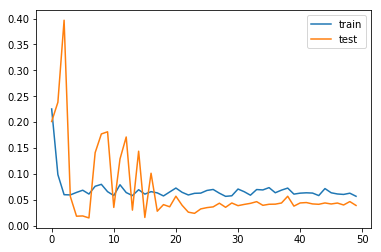

In [273]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from matplotlib import pyplot
# design network
model = Sequential()
model.add(LSTM(64, input_shape=(scaled_train_X.shape[1], scaled_train_X.shape[2])))
model.add(Dense(32, activation = 'relu'))
#model.add(Dense(32, activation = 'relu'))
model.add(Dense(1,  activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam')
# fit network
history = model.fit(scaled_train_X, train_Y, epochs=50, batch_size=72, validation_data=(scaled_test_X, test_Y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [274]:
test['pred'] = model.predict(scaled_test_X)

/Users/ozalmanson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
